In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from funcoes import clf_eval

## Contextualizando

O meu trabalho é sobre Dados que foram coletados apartir de uma imagem digitalizada de um aspirado por agulha fina (PAAF) de uma massa mamária. Eles descrevem características dos núcleos celulares presentes na imagem.

Apartir dai, temos vários dados quantitativos que representam algumas coisas e temos uma coluna de dados qualitativa, os dados do Diagnostico. Esses dados a principio era uma coluna de B's e M's, onde B significava Benigno, enquanto M significava Maligno. Porém para rodar os modelos e desenvolver uma forma de avaliar se o tumor é benigno ou maligno dado apenas os dados quantitativos da interpretação da imagem.

O objetivo ao fazer a analise dos dados era prever prever os malignos como malignos e os benignos como benignos ou seja a métrica de interesse era a acurácia.

Antes de falar de acurácia, vamos definir algumas coisas:
+ $VP$ (Verdadeiro positivo) será quando o modelo prever $M$ e target for $M$
+ $FP$ (Falso Positivo) será quando o modelo prever $M$ porém o target é $B$ 
+ $FN$ (Falso Negativo) será quando o modelo prever $B$ enquanto o real é $M$
+ $VN$ (Verdadeiro Negativo) será quando o modelo prever $B$ e realmente for $B$

Portanto a acurácia seria:
$$Acuracia = \frac{VP+VN}{VP+FP+FN+VN}$$
Esse valor é legal de ser analisado e também diz bastante sobre a quantidade de acertos que o modelo tem. Porém, acho que seria bom analisar outras métricas como Precisão e Recall.
$$PrecisãoM = \frac{TP}{TP+FP}$$

$$RecallM = \frac{TP}{TP+FN}$$

Acho que dados os meus dados é tão importante observar o Recall de Malignos, quanto analisar a Acurácia. Os meus dados tem  357 benignos enquanto tem 212 malignos como target, acho que não é um problema para predizer, porém é necessário ter cuidado na hora de analisar os resultados, pois os dados cerca de $\frac{3}{5}$ são Benignos enquanto apenas cerca $\frac{2}{5}$ são malignos, tem um desbalanciamento, porém não é tão grande e acredito que apenas tomando cuidado com as medidas de avaliação seja possível desenvolver o melhor modelo. Além disso, acho importante analisar o Recall dos Malignos, pois a previsão de Falsos Negativos é mais negativo que os Falsos Positivos, $FP$ acarretam alguns danos como uma ansiedade, preocupação das pessoas que foram diagnosticadas e da família dela, porém o $FN$ pode ser pior, a pessoa em questão acredita que o tumor é benigno e para o tratamento, levando em um aumento da doença e numa menor chance de cura, possivelmente levando a óbito.

## Resumo dos Passos...

- Ler os dados
    - Trocar M por 1 e B por 0 na variável diagnostico
- Separar os dados entre treino e teste
- Testar alguns modelos com os dados
- Escolher o melhor modelo e chegar a uma conclusão

## Leitura dos Dados

Aqui abrimos os dados que já utilizamos no trabalho 1 e convertemos B para 0 e M para 1:

In [2]:
df = pd.read_csv('cancer.csv')
df2 = df.copy() # df2 é para descobrir a correlação com as outras variáveis.
df2['diagnosis'] = df2['diagnosis'].replace('M', 1)
df2['diagnosis'] = df2['diagnosis'].replace('B', 0)
df2.diagnosis.astype('int64')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   diagnosis               569 non-null    int64  
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   perimeter_mean          569 non-null    float64
 5   area_mean               569 non-null    float64
 6   smoothness_mean         569 non-null    float64
 7   compactness_mean        569 non-null    float64
 8   concavity_mean          569 non-null    float64
 9   concave points_mean     569 non-null    float64
 10  symmetry_mean           569 non-null    float64
 11  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 53.5 KB


Observando os valores que usaremos para prever, ou seja, o X:

In [3]:
df2.iloc[:,2:]

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016


Os dados qualitativos do diagnostico, ou seja, o y:

In [4]:
df2.iloc[:,1]

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

## Treino e Teste

Pegando o $X$ e o $y$ e separando $70%$ dos dados para treinar os modelos, enquanto os outros $30%$ estão destinados para testar o modelo e nós dizer uma métrica.   

In [5]:
from sklearn import model_selection

## Creating validation set with cross validation
X_train, X_test, y_train, y_test = model_selection.train_test_split(df2.iloc[:,2:], df2.iloc[:,1], test_size=0.3, random_state=0)


In [339]:
resultados = pd.DataFrame(columns=(['modelo','acuracia','recall']))

## Naive Bayes

O primeiro modelo que resolvi rodar foi o Naive Bayes, que é um modelo ingenuo, e surpreendentemente deu um resultado bom.

Resultados:
              precision    recall  f1-score   support

     Benigno       0.92      0.93      0.92       108
     Maligno       0.87      0.86      0.86        63

    accuracy                           0.90       171
   macro avg       0.89      0.89      0.89       171
weighted avg       0.90      0.90      0.90       171

ROC: 0.8915343915343915
Acurácia : 0.9005847953216374
Precisão : 0.7991753577492118
Recall : 0.8571428571428571
f1 : 0.864


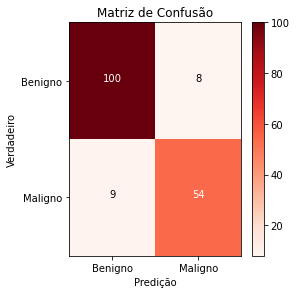

In [348]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB().fit(X_train, y_train)

resultados = clf_eval(clf_gnb, X_test, y_test,'Naive Bayes', resultados)

In [349]:
resultados

,modelo,acuracia,recall
0,Naive Bayes,0.900585,0.857143


## KNN

In [350]:
from sklearn.neighbors import KNeighborsClassifier

In [351]:
for b in ['uniform','distance']:
    for a in [5,10,15,20,25,35,45,50,55,65,75]:
        clf_knn = KNeighborsClassifier(n_neighbors=a,weights=b).fit(X_train, y_train)
        y_pred=clf_knn.predict(X_test)
        print(b,a,accuracy_score(y_test, y_pred))

uniform 5 0.9005847953216374
uniform 10 0.9064327485380117
uniform 15 0.9005847953216374
uniform 20 0.9181286549707602
uniform 25 0.9181286549707602
uniform 35 0.9122807017543859
uniform 45 0.9181286549707602
uniform 50 0.9122807017543859
uniform 55 0.9181286549707602
uniform 65 0.9064327485380117
uniform 75 0.9122807017543859
distance 5 0.9005847953216374
distance 10 0.9122807017543859
distance 15 0.9181286549707602
distance 20 0.9181286549707602
distance 25 0.9239766081871345
distance 35 0.9181286549707602
distance 45 0.9181286549707602
distance 50 0.9181286549707602
distance 55 0.9181286549707602
distance 65 0.9181286549707602
distance 75 0.9181286549707602


Resultados:
              precision    recall  f1-score   support

     Benigno       0.91      0.98      0.94       108
     Maligno       0.96      0.83      0.89        63

    accuracy                           0.92       171
   macro avg       0.93      0.90      0.92       171
weighted avg       0.93      0.92      0.92       171

ROC: 0.9034391534391534
Acurácia : 0.9239766081871345
Precisão : 0.8591540579844673
Recall : 0.8253968253968254
f1 : 0.8888888888888888


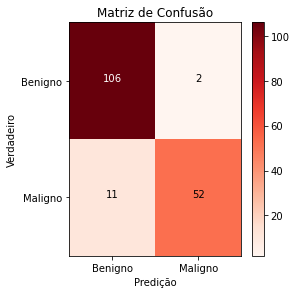

In [352]:
clf_knn = KNeighborsClassifier(n_neighbors=25,weights='distance').fit(X_train, y_train)

resultados = clf_eval(clf_knn, X_test, y_test,'KNN',resultados)

## SVM - Demora uma eternidade Desisti!!!!

In [ ]:
from sklearn import svm

estimator = svm.SVC()

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = np.linspace(0.1,3,4)
degrees = [2,3,4,5]
gammas = np.logspace(-5, 0, 7)

param_grid=dict(kernel=kernels, C=Cs, gamma=gammas, degree=degrees)

clf_svc = model_selection.RandomizedSearchCV(estimator=estimator,
                                             cv=cv,
                                             param_distributions=param_grid, 
                                             n_jobs=-1).fit(X_train, y_train)

In [48]:
print(clf_svc.best_score_) #0.9372468354430378
print(clf_svc.best_estimator_.kernel) # poly
print(clf_svc.best_estimator_.C) #2.033333333333333
print(clf_svc.best_estimator_.degree)#2
print(clf_svc.best_estimator_.gamma)#1.0

0.9372468354430378
poly
2.033333333333333
2
1.0


Resultados:
              precision    recall  f1-score   support

     Benigno       0.97      0.93      0.95       108
     Maligno       0.88      0.95      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

ROC: 0.9391534391534392
Acurácia : 0.935672514619883
Precisão : 0.8578799941029043
Recall : 0.9523809523809523
f1 : 0.916030534351145


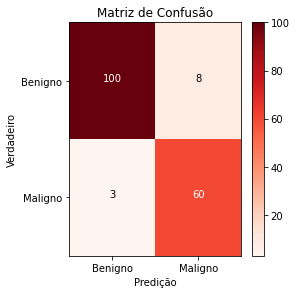

In [353]:
from sklearn import svm
clf_svc2 = svm.SVC(kernel='poly',
                   C=2.033333333333333,
                   degree=2, 
                   gamma=1.0
                  ).fit(X_train, y_train)

resultados = clf_eval(clf_svc2, X_test, y_test,'SVM', resultados)

## Logistic Regression

In [203]:
from sklearn.linear_model import LogisticRegression

estimatorLR = LogisticRegression()

Cs = np.linspace(0.01,11,11)
tol = np.linspace(0.0000000001,0.01,10)
param_grid=dict(penalty=['l1','l2','elasticnet'], C=Cs,solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    multi_class = ['ovr', 'multinomial'],tol=tol)

clf_LR= model_selection.RandomizedSearchCV(estimator=estimatorLR,
                                             scoring='recall',
                                             param_distributions=param_grid, 
                                             n_jobs=-1).fit(X_train, y_train)

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.85908046 0.85287356        nan 0.85287356 0.67103448 0.82574713
 0.87241379 0.66436782 0.66436782 0.66436782]
  warnings.warn(


In [204]:
clf_LR.best_estimator_

LogisticRegression(C=7.702999999999999, multi_class='ovr', penalty='l1',
                   solver='liblinear', tol=0.0033333334000000005)

In [205]:
clf_LR.best_score_

0.8724137931034482

Resultados:
              precision    recall  f1-score   support

     Benigno       0.95      0.97      0.96       108
     Maligno       0.95      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

ROC: 0.9384920634920634
Acurácia : 0.9473684210526315
Precisão : 0.8946115288220551
Recall : 0.9047619047619048
f1 : 0.9268292682926829


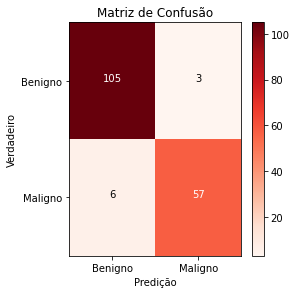

In [354]:
clf_LR = LogisticRegression(C=7.702999999999999, multi_class='ovr', penalty='l1',
                   solver='liblinear', tol=0.0033333334000000005).fit(X_train, y_train)

resultados= clf_eval(clf_LR, X_test, y_test,'Reg. Logistica',resultados)

## Arvore de Decisão

In [155]:
from sklearn.tree import DecisionTreeClassifier

In [372]:
e = DecisionTreeClassifier(random_state=42)
param_grid=dict(criterion=['gini', 'entropy', 'log_loss'],splitter=['best','random'])
clf_LR= model_selection.GridSearchCV(estimator=e,
                                     scoring='recall',
                                     param_grid=param_grid, 
                                     n_jobs=-1).fit(X_train, y_train)

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.88574713 0.89954023 0.88597701 0.87885057        nan        nan]
  warnings.warn(


In [373]:
clf_LR.best_estimator_

DecisionTreeClassifier(random_state=42, splitter='random')

In [370]:
clf_LR.best_score_

0.8995402298850574

Resultados:
              precision    recall  f1-score   support

     Benigno       0.91      0.96      0.94       108
     Maligno       0.93      0.84      0.88        63

    accuracy                           0.92       171
   macro avg       0.92      0.90      0.91       171
weighted avg       0.92      0.92      0.92       171

ROC: 0.9021164021164022
Acurácia : 0.9181286549707602
Precisão : 0.8407128933444723
Recall : 0.8412698412698413
f1 : 0.8833333333333334


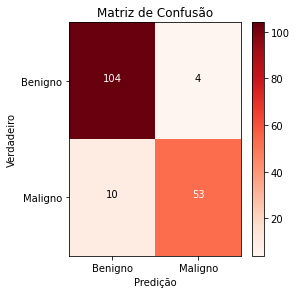

In [380]:
clf_dtc = DecisionTreeClassifier(splitter='random', random_state=42
                                ).fit(X_train, y_train)

resultados = clf_eval(clf_dtc, X_test, y_test,'Arvore de Decisão',resultados)

## Random Forest

In [219]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)



param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = model_selection.GridSearchCV(estimator=rf, scoring = 'recall', param_grid=param_grid, cv= 5).fit(X_train, y_train)

In [220]:
rfc.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=500,
                       random_state=42)

In [221]:
rfc.best_score_

0.9195402298850575

Resultados:
              precision    recall  f1-score   support

     Benigno       0.96      0.94      0.95       108
     Maligno       0.89      0.94      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

ROC: 0.9358465608465609
Acurácia : 0.935672514619883
Precisão : 0.8605731500468342
Recall : 0.9365079365079365
f1 : 0.9147286821705426


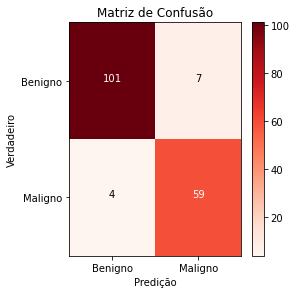

In [356]:
clf_rf = RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200,
                       random_state=42).fit(X_train, y_train)


resultados = clf_eval(clf_rf, X_test, y_test, 'Random Forest', resultados)

## Processo Gaussiano

In [225]:
from sklearn.gaussian_process import GaussianProcessClassifier

gridP = {'optimizer': ['fmin_l_bfgs_b', 'lbfgs', 'sgd', 'rmsprop', 'adam']}

gp = GaussianProcessClassifier()

gaussian = model_selection.GridSearchCV(estimator=gp, param_grid=gridP, scoring = 'recall').fit(X_train, y_train)

In [226]:
gaussian.best_estimator_

GaussianProcessClassifier()

In [227]:
gaussian.best_score_

0.7917241379310344

Resultados:
              precision    recall  f1-score   support

     Benigno       0.88      0.92      0.90       108
     Maligno       0.84      0.78      0.81        63

    accuracy                           0.87       171
   macro avg       0.86      0.85      0.85       171
weighted avg       0.86      0.87      0.86       171

ROC: 0.8472222222222222
Acurácia : 0.8654970760233918
Precisão : 0.7389594676346037
Recall : 0.7777777777777778
f1 : 0.8099173553719008


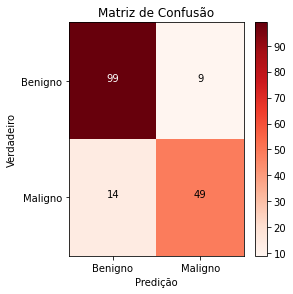

In [357]:
clf_gpc = GaussianProcessClassifier().fit(X_train, y_train)

resultados = clf_eval(clf_gpc, X_test, y_test,'Gausian Process', resultados)

## Perceptron - ACONTECEU ALGO BEM ERRADO

In [277]:
from sklearn.linear_model import Perceptron

Percep = Perceptron()
gripP={'penalty':['l2','l1','elasticnet'],'alpha':np.linspace(0.00001,100,11),'tol' : np.linspace(0.00001,0.01,10)}

perc = model_selection.GridSearchCV(estimator=Percep, param_grid=gripP, scoring = 'accuracy').fit(X_train, y_train)

In [278]:
perc.best_estimator_

Perceptron(alpha=1e-05, penalty='l2', tol=1e-05)

In [279]:
perc.best_score_

0.7590189873417721

Resultados:
              precision    recall  f1-score   support

     Benigno       0.00      0.00      0.00       108
     Maligno       0.37      1.00      0.54        63

    accuracy                           0.37       171
   macro avg       0.18      0.50      0.27       171
weighted avg       0.14      0.37      0.20       171

ROC: 0.5
Acurácia : 0.3684210526315789
Precisão : 0.3684210526315789
Recall : 1.0
f1 : 0.5384615384615384


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,modelo,acuracia,recall
0,Naive Bayes,0.900585,0.857143
1,KNN,0.923977,0.825397
2,SVM,0.935673,0.952381
3,Reg. Logistica,0.947368,0.904762
4,Arvore de Decisão,0.923977,0.857143
5,Random Forest,0.935673,0.936508
6,Gausian Process,0.865497,0.777778
7,Perceptron,0.368421,1.000000


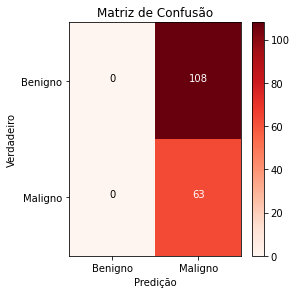

In [358]:
clf_pcp = Perceptron(alpha=20.000007999999998, penalty='l1', tol=1e-05).fit(X_train, y_train)

clf_eval(clf_pcp, X_test, y_test,'Perceptron',resultados)

## SGDC Classifier

In [270]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier()
gridS={'loss':["hinge", "log", "modified_huber", "perceptron", "squared_hinge"],'max_iter': [5, 10, 20, 50, 100, 1000],
        'penalty':['l2', 'l1', 'elasticnet'],'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10]}

sg = model_selection.GridSearchCV(estimator=sgdc, param_grid=gridS, scoring = 'accuracy').fit(X_train, y_train)



C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before conv

In [271]:
sg.best_estimator_

SGDClassifier(alpha=1, loss='squared_hinge', max_iter=20, penalty='l1')

In [272]:
sg.best_score_

0.8567088607594936

Resultados:
              precision    recall  f1-score   support

     Benigno       0.92      0.83      0.87       108
     Maligno       0.75      0.87      0.81        63

    accuracy                           0.85       171
   macro avg       0.84      0.85      0.84       171
weighted avg       0.86      0.85      0.85       171

ROC: 0.8531746031746033
Acurácia : 0.847953216374269
Precisão : 0.7045353108799396
Recall : 0.873015873015873
f1 : 0.8088235294117647


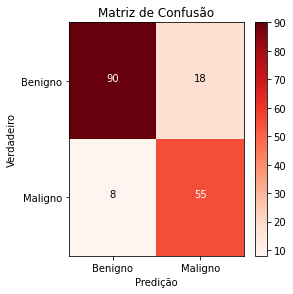

In [360]:
clf_sgdc = SGDClassifier(alpha=1, loss='squared_hinge', max_iter=20, penalty='l1').fit(X_train, y_train)

resultados = clf_eval(clf_sgdc, X_test, y_test,'SGDC',resultados)

## Testando algo diferente...

Raio, Area e Perimetro são altamente correlacionados, como eu disse no primeiro trabalho, acho que Area e Perimetro são derivados do Raio, então vou testar alguns modelos sem essas variavéis.

In [295]:
df3 = df2.drop(['perimeter_mean','area_mean'],axis=1)

In [296]:
X_train1, X_test1, y_train1, y_test1 = model_selection.train_test_split(df3.iloc[:,2:], df3.iloc[:,1],
                                                                        test_size=0.3, random_state=0)


Resultados:
              precision    recall  f1-score   support

     Benigno       0.92      0.90      0.91       108
     Maligno       0.83      0.87      0.85        63

    accuracy                           0.89       171
   macro avg       0.88      0.89      0.88       171
weighted avg       0.89      0.89      0.89       171

ROC: 0.8855820105820106
Acurácia : 0.8888888888888888
Precisão : 0.7742968532442217
Recall : 0.873015873015873
f1 : 0.8527131782945736


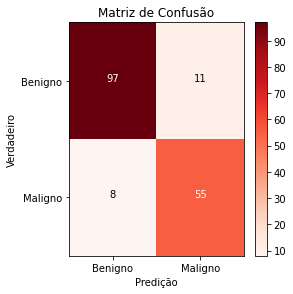

In [361]:
from sklearn.naive_bayes import GaussianNB

clf_gnb1 = GaussianNB().fit(X_train1, y_train1)

resultados = clf_eval(clf_gnb1, X_test1, y_test1,'NB - 1', resultados)

In [298]:
rf1 = RandomForestClassifier(random_state=42)



param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc1 = model_selection.GridSearchCV(estimator=rf1, scoring = 'recall', param_grid=param_grid, cv= 5).fit(X_train1, y_train1)

In [299]:
rfc1.best_estimator_

RandomForestClassifier(max_depth=6, n_estimators=500, random_state=42)

Resultados:
              precision    recall  f1-score   support

     Benigno       0.94      0.94      0.94       108
     Maligno       0.89      0.90      0.90        63

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171

ROC: 0.919973544973545
Acurácia : 0.9239766081871345
Precisão : 0.840891290726817
Recall : 0.9047619047619048
f1 : 0.8976377952755906


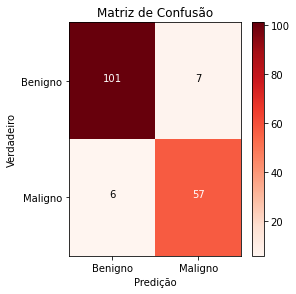

In [362]:
rf1 = RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42).fit(X_train1, y_train1)

resultados = clf_eval(rf1, X_test1, y_test1,'RF - 1',resultados)

## E se em vez de tirar os correlacionados, retirar os que tem menor correlação com a resposta


In [307]:
df4 = df2.drop(['fractal_dimension_mean','symmetry_mean','smoothness_mean'],axis=1)

In [308]:
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(df4.iloc[:,2:], df4.iloc[:,1],
                                                                        test_size=0.3, random_state=0)

Resultados:
              precision    recall  f1-score   support

     Benigno       0.92      0.93      0.92       108
     Maligno       0.87      0.86      0.86        63

    accuracy                           0.90       171
   macro avg       0.89      0.89      0.89       171
weighted avg       0.90      0.90      0.90       171

ROC: 0.8915343915343915
Acurácia : 0.9005847953216374
Precisão : 0.7991753577492118
Recall : 0.8571428571428571
f1 : 0.864


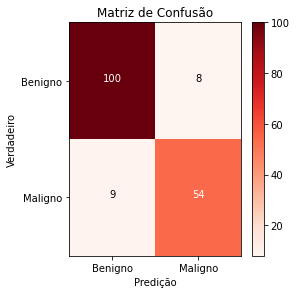

In [364]:
clf_gnb2 = GaussianNB().fit(X_train2, y_train2)

resultados = clf_eval(clf_gnb2, X_test2, y_test2,'NB - 2', resultados)

In [310]:
rf2 = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc2 = model_selection.GridSearchCV(estimator=rf2, scoring = 'recall', param_grid=param_grid, cv= 5).fit(X_train2, y_train2)

In [311]:
rfc2.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=42)

Resultados:
              precision    recall  f1-score   support

     Benigno       0.96      0.94      0.95       108
     Maligno       0.89      0.94      0.91        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171

ROC: 0.9358465608465609
Acurácia : 0.935672514619883
Precisão : 0.8605731500468342
Recall : 0.9365079365079365
f1 : 0.9147286821705426


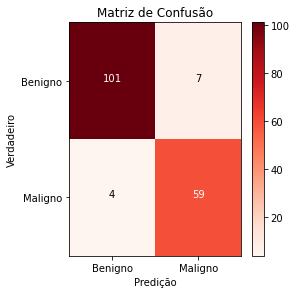

In [365]:
rf2 = RandomForestClassifier(max_depth=4, n_estimators=500, random_state=42).fit(X_train2, y_train2)

resultados = clf_eval(rf2, X_test2, y_test2,'RF - 2',resultados)

In [366]:
resultados

,modelo,acuracia,recall
0,Naive Bayes,0.900585,0.857143
1,KNN,0.923977,0.825397
2,SVM,0.935673,0.952381
3,Reg. Logistica,0.947368,0.904762
4,Arvore de Decisão,0.923977,0.857143
5,Random Forest,0.935673,0.936508
6,Gausian Process,0.865497,0.777778
7,Ridge,0.918129,0.857143
8,SGDC,0.847953,0.873016
9,NB - 1,0.888889,0.873016


In [ ]:
df5 = df2.drop(['perimeter_mean','area_mean','fractal_dimension_mean','symmetry_mean','smoothness_mean'],axis=1)
X_train3, X_test3, y_train3, y_test3 = model_selection.train_test_split(df5.iloc[:,2:], df5.iloc[:,1],
                                                                        test_size=0.3, random_state=0)

In [ ]:
clf_gnb3 = GaussianNB().fit(X_train3, y_train3)

resultados = clf_eval(clf_gnb3, X_test3, y_test3,'NB - 3', resultados)

In [ ]:
rf3 = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc3 = model_selection.GridSearchCV(estimator=rf3, scoring = 'recall', param_grid=param_grid, cv= 5).fit(X_train3, y_train3)
rfc3.best_estimator_

In [ ]:
rf3 = RandomForestClassifier(max_depth=4, n_estimators=500, random_state=42).fit(X_train3, y_train3)

resultados = clf_eval(rf3, X_test3, y_test3,'RF - 3',resultados)

## Conclusão

Acredito que os modelos foram satisfatórios, e eu diria que a Random Forest, foi o modelo que melhor previu os dados. Isso porque mesmo não tendo a melhor acurácia, teve o melhor recall e teve uma acurácia muito próxima do modelo que teve a maior.

Além disso, eu queria resaltar um importante ponto, o modelo deu certo tem uma taxa de acerto bem grande ao predizer se o tumor é maligno ou benigno, porém ele é inútil para pessoas "normais", para ele funcionar relativamente bem, as pessoas que vão sofrer a avaliação do modelo tem estar minimamente padronizadas com os dados que foram dados para modelar a questão. Como os dados são de exames de cancer de mama com pessoas que já tem o cancer diagnosticado, não é conveniente chegar e em pessoas que não estão sentido nada e fazer um teste com elas, o modelo com certeza perderia a eficiencia, pois os pre reqisitos na hora de colher os dados não estaram sendo compridos.

### Outros:
Estão no [GITHUB](https://github.com/CarCesar/ML/tree/main/A2):
+ O arquivo funcoes contem as funções que foram usadas para avaliar o modelo.
+ O notebook com todos os passos, (aqui eu resumi um pouco de código para não poluir tanto)